In [1]:
import os
import mne
import json
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

from scipy.signal import iirfilter, sosfiltfilt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

### Read data

In [2]:
persons = os.listdir('C:/Users/amina/YandexDisk/Загрузки/N=22 (hdEEG)/predprocessed')

In [3]:
list_epochs = []
list_epochs_ts = []
for p in persons:
    list_epochs.append(mne.read_epochs('C:/Users/amina/YandexDisk/Загрузки/N=22 (hdEEG)/predprocessed/' + p + '/epochs_ICA/' + p + '_TI_epochsICA.fif', verbose=False))
    list_epochs_ts.append(mne.read_epochs('C:/Users/amina/YandexDisk/Загрузки/N=22 (hdEEG)/predprocessed/' + p + '/epochs_ICA/' + p + '_TS_epochsICA.fif', verbose=False))

In [4]:
list_epochs[13] = list_epochs[13].filter(1, 30, verbose=False)
list_epochs_ts[13] = list_epochs_ts[13].filter(1, 30, verbose=False)

In [5]:
list_labels = []
list_labels_ts = []
for id, epochs in enumerate(list_epochs):
    if id != 13:
        list_labels.append(epochs.events[:, -1] - 2)
    else:
        list_labels.append(epochs.events[:, -1] - 10001)
for id, epochs in enumerate(list_epochs_ts):
    if id != 13:
        list_labels_ts.append(epochs.events[:, -1] - 2)
    else:
        list_labels_ts.append(epochs.events[:, -1] - 10001)

In [6]:
len(list_labels)

22

### LDA

In [8]:
freq_bands = [[8, 10], [10, 13], [13, 20], [20, 26], [8, 13], [13, 26], [8, 26], [10, 16]]
n_components = 4
new_freq = 250

In [10]:
report = {}

for id in tqdm(range(len(list_epochs))):
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    for freq_band_id in range(len(freq_bands)):
        try:
            freq_band = freq_bands[freq_band_id]

            epochs_resampled = epochs.copy().resample(new_freq, verbose=False)
            epochs_filtered = epochs_resampled.filter(freq_band[0], freq_band[1], verbose=False)
            data = epochs_filtered.get_data()
            filter = iirfilter(4, [freq_band[0] / new_freq, freq_band[1] / new_freq], btype='bandpass', ftype='butter', output='sos')
            filtered = sosfiltfilt(filter, data)

            csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
            lda = LDA()

            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
            clf = make_pipeline(csp, lda)
            scores = cross_val_score(clf, filtered, list_labels[id], cv=cv, n_jobs=1, scoring='accuracy')
            report[name][freq_band_id] = np.mean(scores)
        except Exception as e:
            print('FAILED WITH', e)

    cur_best_score = 0
    cur_best_freq = 0
    for k, v in report[name].items():
        if v > cur_best_score:
            cur_best_score = v
            cur_best_freq = freq_bands[k]
    report[name]['best_freq'] = cur_best_freq
    report[name]['best_score'] = cur_best_score

with open('report_acc.json', 'w') as f:
    json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 127 dim * 6.4e+07  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 127 dim * 6.6e+07  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 127 dim * 5.9e+07  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.

In [45]:
new_report = {}
for k, v in report.items():
    new_v = {'best_freq': v['best_freq'], 'best_score': v['best_score']}
    for key in v:
        if isinstance(key, tuple):
            for i, f in enumerate(freq_bands):
                if key[0] == f[0] and key[1] == f[1]:
                    new_v[i] = v[key]
    new_report[k] = new_v
with open('report.json', 'w') as f:
    json.dump(new_report, f)

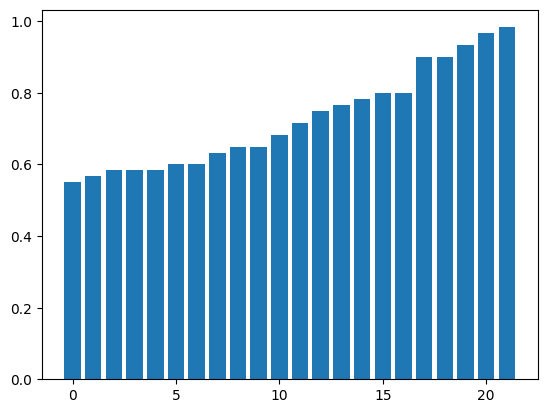

In [18]:
results = []
for k, v in report.items():
    results.append(v['best_score'])

plt.bar(list(range(len(results))), sorted(results))
plt.show()

In [27]:
np.mean(results)

0.7265151515151516

In [28]:
np.std(results)

0.13740553145147355

In [23]:
result_by_freq_band = {}
for k, v in report.items():
    for key in v:
        if isinstance(key, int):
            if key in result_by_freq_band:
                result_by_freq_band[key]['vals'].append(v[key])
            else:
                result_by_freq_band[key] = {'vals': [v[key]]}

for k, v in result_by_freq_band.items():
    result_by_freq_band[k]['mean'] = np.mean(v['vals'])
    result_by_freq_band[k]['std'] = np.std(v['vals'])

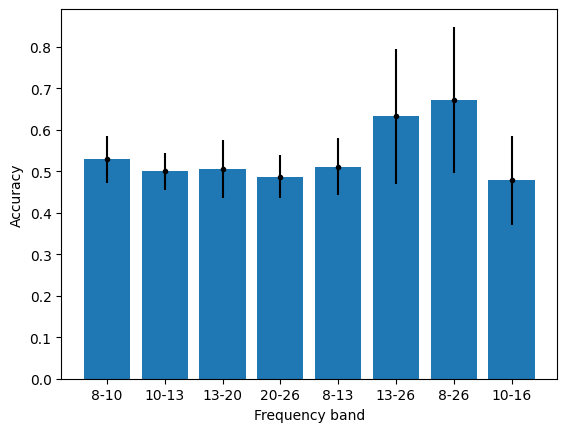

In [41]:
plt.bar(list(result_by_freq_band.keys()), [x['mean'] for x in result_by_freq_band.values()])
plt.errorbar(list(result_by_freq_band.keys()), [x['mean'] for x in result_by_freq_band.values()], [x['std'] for x in result_by_freq_band.values()], color='black', fmt='.')
plt.xticks(list(result_by_freq_band.keys()), labels=[f'{freq_bands[x][0]}-{freq_bands[x][1]}' for x in result_by_freq_band.keys()])
plt.xlabel('Frequency band')
plt.ylabel('Accuracy')
plt.show()

### SVM

In [9]:
freq_bands = [[8, 10], [10, 13], [13, 20], [20, 26], [8, 13], [13, 26], [8, 26], [10, 16]]
n_components = 4
new_freq = 250

In [11]:
report = {}

for id in tqdm(range(len(list_epochs))):
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    for freq_band_id in range(len(freq_bands)):
        try:
            freq_band = freq_bands[freq_band_id]

            epochs_resampled = epochs.copy().resample(new_freq, verbose=False)
            epochs_filtered = epochs_resampled.filter(freq_band[0], freq_band[1], verbose=False)
            data = epochs_filtered.get_data()
            filter = iirfilter(4, [freq_band[0] / new_freq, freq_band[1] / new_freq], btype='bandpass', ftype='butter', output='sos')
            filtered = sosfiltfilt(filter, data)

            csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
            svm = SVC(kernel='rbf', random_state=92)

            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
            clf = make_pipeline(csp, svm)
            scores = cross_val_score(clf, filtered, list_labels[id], cv=cv, n_jobs=1, scoring='accuracy')
            report[name][freq_band_id] = {'mean': np.mean(scores), 'std': np.std(scores)}
        except Exception as e:
            print('FAILED WITH', e)

    cur_best_score = 0
    cur_best_freq = 0
    for k, v in report[name].items():
        if v['mean'] > cur_best_score:
            cur_best_score = v['mean']
            cur_best_freq = freq_bands[k]
    report[name]['best_freq'] = cur_best_freq
    report[name]['best_score'] = cur_best_score

with open('reports/report_acc_svm.json', 'w') as f:
    json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 127 dim * 6.4e+07  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 127 dim * 6.6e+07  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 127 dim * 5.9e+07  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.

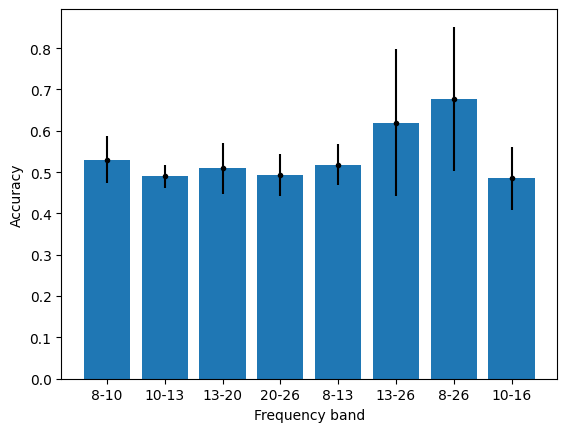

In [31]:
result_by_freq_band = {}
for k, v in report.items():
    for key in v:
        try:
            key = int(key)
            if key in result_by_freq_band:
                result_by_freq_band[key]['vals'].append(v[str(key)])
            else:
                result_by_freq_band[key] = {'vals': [v[str(key)]]}
        except Exception as e:
            continue

for k, v in result_by_freq_band.items():
    result_by_freq_band[k]['mean'] = np.mean(v['vals'])
    result_by_freq_band[k]['std'] = np.std(v['vals'])

plt.bar(list(result_by_freq_band.keys()), [x['mean'] for x in result_by_freq_band.values()])
plt.errorbar(list(result_by_freq_band.keys()), [x['mean'] for x in result_by_freq_band.values()], [x['std'] for x in result_by_freq_band.values()], color='black', fmt='.')
plt.xticks(list(result_by_freq_band.keys()), labels=[f'{freq_bands[x][0]}-{freq_bands[x][1]}' for x in result_by_freq_band.keys()])
plt.xlabel('Frequency band')
plt.ylabel('Accuracy')
plt.show()

In [37]:
from scipy.stats import wilcoxon

wilcoxon(results, results_lda)

WilcoxonResult(statistic=49.5, pvalue=0.1160131254246709)

# Detect peak mu-rhythm

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

In [9]:
def plot_and_save(rest_freqs, rest_psd_mean, ti_freqs, ti_psd_mean, freq, mu_low, mu_high, beta_low, beta_high, fname):
    plt.figure(figsize=(10, 6))
    plt.plot(rest_freqs, rest_psd_mean, label='rest')
    plt.plot(ti_freqs, ti_psd_mean, label='TI')

    ##MU RHYTHM AREA
    plt.axvline(freq, color='gray', linestyle='--', lw=0.5, label=f'f0={freq} Hz')
    plt.text(freq, 0, 'f0')
    plt.axvline(mu_low, color='gray', linestyle='--', lw=0.5, label=f'mu_l={mu_low} Hz')
    plt.text(mu_low, 0, 'mu_l')
    plt.axvline(mu_high, color='gray', linestyle='--', lw=0.5, label=f'mu_h={mu_high} Hz')
    plt.text(mu_high, 0, 'mu_h')

    ##BETA RHYTHM AREA
    plt.axvline(freq*2, color='gray', linestyle='--', lw=0.5, label=f'f1={freq*2} Hz')
    plt.text(freq*2, 0, 'f1')
    plt.axvline(beta_low, color='gray', linestyle='--', lw=0.5, label=f'b_l={beta_low} Hz')
    plt.text(beta_low, 0, 'b_l')
    plt.axvline(beta_high, color='gray', linestyle='--', lw=0.5, label=f'b_h={beta_high} Hz')
    plt.text(beta_high, 0, 'b_h')


    plt.fill_between(rest_freqs, rest_psd_mean, alpha=0.15)

    plt.title('Power Spectral Density (PSD)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.legend(loc='upper right')
    plt.savefig(f'logs/plots/{fname}.png')
    plt.close()

def get_mu_and_beta(rest_epochs, ti_epochs, save=True, fname='tmp'):
    rest_psds, rest_freqs = rest_epochs.compute_psd('multitaper', fmin=3.0, fmax=30.0, picks='C3', verbose=False).get_data(return_freqs=True)
    ti_psds, ti_freqs = ti_epochs.compute_psd('multitaper', fmin=3.0, fmax=30.0, picks='C3', verbose=False).get_data(return_freqs=True)

    rest_psd_mean = np.mean(rest_psds, axis=0)[0]
    ti_psd_mean = np.mean(ti_psds, axis=0)[0]

    mu_range_idx = np.where((rest_freqs >= 8.0) & (rest_freqs <= 14.0))[0]
    max_psd = rest_psd_mean[mu_range_idx].max()
    freq = round(rest_freqs[mu_range_idx][np.argmax(rest_psd_mean[mu_range_idx])], 1)

    mu_low = freq-2
    mu_high = freq+2

    beta_low = freq*2-2
    beta_high = freq*2+2
    if save:
        plot_and_save(rest_freqs, rest_psd_mean, ti_freqs, ti_psd_mean, freq, mu_low, mu_high, beta_low, beta_high, fname)

    return freq, mu_low, mu_high, beta_low, beta_high

def calculate_erds_baseline(mu_low, mu_high, rest_epochs):
    freqs = np.arange(mu_low, mu_high + 1)
    rest_power = rest_epochs.compute_tfr('morlet', freqs=freqs, n_cycles=5, return_itc=False, average=False, verbose=False)
    baseline_power = rest_power.data.mean(axis=0)
    return baseline_power

def calculate_erds(mu_low, mu_high, rest_epochs, ti_epochs, baseline=None):
    freqs = np.arange(mu_low, mu_high + 1)
    task_power = ti_epochs.compute_tfr('morlet', freqs=freqs, n_cycles=5, return_itc=False, average=False, verbose=False)
    if baseline is None:
        rest_power = rest_epochs.compute_tfr('morlet', freqs=freqs, n_cycles=5, return_itc=False, average=False, verbose=False)
        baseline_power = rest_power.data.mean(axis=0)

        erd_ers = (task_power.data - baseline_power) / baseline_power * 100
        erd_ers_avg_mu = erd_ers.mean(axis=(-1))
        erd_ers_base = (rest_power.data - baseline_power) / baseline_power * 100
        erd_ers_avg_base_mu = erd_ers_base.mean(axis=(-1))
    
        return erd_ers_avg_mu, erd_ers_avg_base_mu
    else:
        erd_ers = (task_power.data - baseline) / baseline * 100
        erd_ers_avg_mu = erd_ers.mean(axis=(-1))
        return erd_ers_avg_mu, None

## Classify just by ERD/ERS

In [11]:
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    # if id == 13:
    #     continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere(list_labels[id][train_id] == 0).flatten()
        ti_ids = np.argwhere(list_labels[id][train_id] == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name)
        
        # erd/ers on train data
        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        baseline_power = calculate_erds_baseline(mu_low, mu_high, rest_epochs)
        erd_ers_avg_mu, erd_ers_avg_base_mu = calculate_erds(mu_low, mu_high, rest_epochs, ti_epochs)
        erd_ers_avg_mu = erd_ers_avg_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)
        erd_ers_avg_base_mu = erd_ers_avg_base_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # erd/ers on test data
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)
        erd_ers_avg_mu_test, _ = calculate_erds(mu_low, mu_high, None, epochs_test_filtered, baseline_power)
        erd_ers_avg_mu_test = erd_ers_avg_mu_test[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # print(erd_ers_avg_mu.shape, erd_ers_avg_base_mu.shape)
        # print(np.concatenate([erd_ers_avg_mu, erd_ers_avg_base_mu], axis=1).shape)
        # print(np.array([1] * erd_ers_avg_mu.shape[0] + [0] * erd_ers_avg_base_mu.shape[0]).shape)
        
        svm = SVC(kernel='rbf')
        svm.fit(np.concatenate([erd_ers_avg_mu, erd_ers_avg_base_mu], axis=0), np.array([1] * erd_ers_avg_mu.shape[0] + [0] * erd_ers_avg_base_mu.shape[0]))
        preds = svm.predict(erd_ers_avg_mu_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = {'mean': np.mean(scores), 'std': np.std(scores)}

    with open('report_acc_erds_svm_rbf.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name)
        
        # erd/ers on train data
        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        baseline_power = calculate_erds_baseline(mu_low, mu_high, rest_epochs)
        erd_ers_avg_mu, erd_ers_avg_base_mu = calculate_erds(mu_low, mu_high, rest_epochs, ti_epochs)
        erd_ers_avg_mu = erd_ers_avg_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)
        erd_ers_avg_base_mu = erd_ers_avg_base_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # erd/ers on test data
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)
        erd_ers_avg_mu_test, _ = calculate_erds(mu_low, mu_high, None, epochs_test_filtered, baseline_power)
        erd_ers_avg_mu_test = erd_ers_avg_mu_test[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # print(erd_ers_avg_mu.shape, erd_ers_avg_base_mu.shape)
        # print(np.concatenate([erd_ers_avg_mu, erd_ers_avg_base_mu], axis=1).shape)
        # print(np.array([1] * erd_ers_avg_mu.shape[0] + [0] * erd_ers_avg_base_mu.shape[0]).shape)
        
        svm = SVC(kernel='linear', random_state=92)
        svm.fit(np.concatenate([erd_ers_avg_mu, erd_ers_avg_base_mu], axis=0), np.array([1] * erd_ers_avg_mu.shape[0] + [0] * erd_ers_avg_base_mu.shape[0]))
        preds = svm.predict(erd_ers_avg_mu_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = np.mean(scores)

    with open('report_acc_erds_svm_lin.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name)
        
        # erd/ers on train data
        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        baseline_power = calculate_erds_baseline(mu_low, mu_high, rest_epochs)
        erd_ers_avg_mu, erd_ers_avg_base_mu = calculate_erds(mu_low, mu_high, rest_epochs, ti_epochs)
        erd_ers_avg_mu = erd_ers_avg_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)
        erd_ers_avg_base_mu = erd_ers_avg_base_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # erd/ers on test data
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)
        erd_ers_avg_mu_test, _ = calculate_erds(mu_low, mu_high, None, epochs_test_filtered, baseline_power)
        erd_ers_avg_mu_test = erd_ers_avg_mu_test[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # print(erd_ers_avg_mu.shape, erd_ers_avg_base_mu.shape)
        # print(np.concatenate([erd_ers_avg_mu, erd_ers_avg_base_mu], axis=1).shape)
        # print(np.array([1] * erd_ers_avg_mu.shape[0] + [0] * erd_ers_avg_base_mu.shape[0]).shape)
        
        svm = KNeighborsClassifier(n_neighbors=3)
        svm.fit(np.concatenate([erd_ers_avg_mu, erd_ers_avg_base_mu], axis=0), np.array([1] * erd_ers_avg_mu.shape[0] + [0] * erd_ers_avg_base_mu.shape[0]))
        preds = svm.predict(erd_ers_avg_mu_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = np.mean(scores)

    with open('report_acc_erds_knn.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
from sklearn.ensemble import RandomForestClassifier


new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name)
        
        # erd/ers on train data
        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        baseline_power = calculate_erds_baseline(mu_low, mu_high, rest_epochs)
        erd_ers_avg_mu, erd_ers_avg_base_mu = calculate_erds(mu_low, mu_high, rest_epochs, ti_epochs)
        erd_ers_avg_mu = erd_ers_avg_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)
        erd_ers_avg_base_mu = erd_ers_avg_base_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # erd/ers on test data
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)
        erd_ers_avg_mu_test, _ = calculate_erds(mu_low, mu_high, None, epochs_test_filtered, baseline_power)
        erd_ers_avg_mu_test = erd_ers_avg_mu_test[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # print(erd_ers_avg_mu.shape, erd_ers_avg_base_mu.shape)
        # print(np.concatenate([erd_ers_avg_mu, erd_ers_avg_base_mu], axis=1).shape)
        # print(np.array([1] * erd_ers_avg_mu.shape[0] + [0] * erd_ers_avg_base_mu.shape[0]).shape)
        
        svm = RandomForestClassifier(n_estimators=100, random_state=92)
        svm.fit(np.concatenate([erd_ers_avg_mu, erd_ers_avg_base_mu], axis=0), np.array([1] * erd_ers_avg_mu.shape[0] + [0] * erd_ers_avg_base_mu.shape[0]))
        preds = svm.predict(erd_ers_avg_mu_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = np.mean(scores)

    with open('report_acc_erds_rf.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

## Classify by thresholding on mu-rhythm

In [12]:
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    # if id == 13:
    #     continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere(list_labels[id][train_id] == 0).flatten()
        ti_ids = np.argwhere(list_labels[id][train_id] == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)
        
        # erd/ers on train data
        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        baseline_power = calculate_erds_baseline(mu_low, mu_high, rest_epochs)
        erd_ers_avg_mu, erd_ers_avg_base_mu = calculate_erds(mu_low, mu_high, rest_epochs, ti_epochs)
        erd_ers_avg_mu = erd_ers_avg_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)
        erd_ers_avg_base_mu = erd_ers_avg_base_mu[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        # erd/ers on test data
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)
        erd_ers_avg_mu_test, _ = calculate_erds(mu_low, mu_high, None, epochs_test_filtered, baseline_power)
        erd_ers_avg_mu_test = erd_ers_avg_mu_test[:, [electrode2id[ch] for ch in electrodes]].reshape(-1, len(electrodes) * 5)

        thresholds_mu = range(int(min(erd_ers_avg_base_mu.mean(axis=1))), int(max(erd_ers_avg_base_mu.mean(axis=1))) + 5, 5)
        threshold2acc = {}
        for threshold in thresholds_mu:
                tp = np.sum(erd_ers_avg_mu.mean(axis=1) > threshold)
                tn = np.sum(erd_ers_avg_base_mu.mean(axis=1) <= threshold)
                fp = np.sum(erd_ers_avg_base_mu.mean(axis=1) > threshold)
                fn = np.sum(erd_ers_avg_mu.mean(axis=1) <= threshold)
                acc = (tp + tn) / (tp + tn + fp + fn)
                threshold2acc[threshold] = acc

        best_threshold = max(threshold2acc, key=threshold2acc.get)
        preds = (erd_ers_avg_mu_test.mean(axis=1) > best_threshold).astype(int)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = {'mean': np.mean(scores), 'std': np.std(scores), 'threshold': best_threshold}

    with open('report_acc_erds_threshold.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

## CSP near peak mu-rhythm

In [33]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])

        # calculate csp, train
        csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = LDA()
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = make_pipeline(csp, lda)
        clf.fit(epochs_filtered.get_data(), list_labels[id][train_id])
        preds = clf.predict(epochs_test_filtered.get_data())
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = np.mean(scores)

    with open('report_acc_erds_csp_lda.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 9 dim * 7.2e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 9 dim * 7.4e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 9 dim * 7.2e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using

In [34]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])

        # calculate csp, train
        csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = SVC(kernel='linear', random_state=92)
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = make_pipeline(csp, lda)
        clf.fit(epochs_filtered.get_data(), list_labels[id][train_id])
        preds = clf.predict(epochs_test_filtered.get_data())
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = np.mean(scores)

    with open('report_acc_erds_csp_svm_linear.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 9 dim * 7.2e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 9 dim * 7.4e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 9 dim * 7.2e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using

In [13]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    # if id == 13:
    #     continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere(list_labels[id][train_id] == 0).flatten()
        ti_ids = np.argwhere(list_labels[id][train_id] == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])

        # calculate csp, train
        csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = SVC(kernel='rbf', random_state=92)
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = make_pipeline(csp, lda)
        clf.fit(epochs_filtered.get_data(), list_labels[id][train_id])
        preds = clf.predict(epochs_test_filtered.get_data())
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = {'mean': np.mean(scores), 'std': np.std(scores)}

    with open('report_acc_erds_csp_svm_rbf_filtered.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 9 dim * 7.2e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 9 dim * 7.4e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 9 dim * 7.2e+08  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using

In [15]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    # if id == 13:
    #     continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere(list_labels[id][train_id] == 0).flatten()
        ti_ids = np.argwhere(list_labels[id][train_id] == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)

        # calculate csp, train
        csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = SVC(kernel='rbf', random_state=92)
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = make_pipeline(csp, lda)
        clf.fit(epochs_filtered.get_data(), list_labels[id][train_id])
        preds = clf.predict(epochs_test_filtered.get_data())
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = {'mean': np.mean(scores), 'std': np.std(scores)}

    with open('report_acc_erds_csp_svm_rbf_all_channels.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

Computing rank from data with rank=None
    Using tolerance 5.2e-05 (2.2e-16 eps * 127 dim * 1.8e+09  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-05 (2.2e-16 eps * 127 dim * 1.8e+09  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-05 (2.2e-16 eps * 127 dim * 1.7e+09  max singular value)
    Estimated rank (data): 127
    data: rank 127 computed from 127 data channels with 0 projectors
Reducing data rank from 127 -> 127
Estimating class=0 covariance using OAS
Done.

## FT near mu peak

In [37]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)

        # calculate psd
        psd_train = epochs_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False, picks=electrodes).data.reshape(len(train_id), -1)
        psd_test = epochs_test_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False, picks=electrodes).data.reshape(len(test_id), -1)
        # csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = LDA()
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = lda
        clf.fit(psd_train, list_labels[id][train_id])
        preds = clf.predict(psd_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)
    report[name] = np.mean(scores)

    with open('report_acc_erds_psd_lda.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

In [10]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    # if id == 13:
    #     continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere(list_labels[id][train_id] == 0).flatten()
        ti_ids = np.argwhere(list_labels[id][train_id] == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)

        # calculate psd
        psd_train = epochs_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False, picks=electrodes).data.reshape(len(train_id), -1)
        psd_test = epochs_test_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False, picks=electrodes).data.reshape(len(test_id), -1)
        # csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = SVC(kernel='rbf', random_state=92)
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = lda
        clf.fit(psd_train, list_labels[id][train_id])
        preds = clf.predict(psd_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)
    report[name] = {'mean': np.mean(scores), 'std': np.std(scores)}
    with open('report_acc_erds_psd_svm_rbf_filtered.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

In [11]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    # if id == 13:
    #     continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere(list_labels[id][train_id] == 0).flatten()
        ti_ids = np.argwhere(list_labels[id][train_id] == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)

        # calculate psd
        psd_train = epochs_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False).data.reshape(len(train_id), -1)
        psd_test = epochs_test_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False).data.reshape(len(test_id), -1)
        # csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = SVC(kernel='rbf', random_state=92)
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = lda
        clf.fit(psd_train, list_labels[id][train_id])
        preds = clf.predict(psd_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)
    report[name] = {'mean': np.mean(scores), 'std': np.std(scores)}

    with open('report_acc_erds_psd_svm_rbf_all_channels.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

In [40]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)

        # calculate psd
        psd_train = epochs_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False, picks=electrodes).data.reshape(len(train_id), -1)
        psd_test = epochs_test_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False, picks=electrodes).data.reshape(len(test_id), -1)
        # csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = SVC(kernel='linear', random_state=92)
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = lda
        clf.fit(psd_train, list_labels[id][train_id])
        preds = clf.predict(psd_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)
    report[name] = np.mean(scores)

    with open('report_acc_erds_psd_svm_linear.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

In [42]:
from sklearn.neighbors import KNeighborsClassifier

n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False)
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False)

        # calculate psd
        psd_train = epochs_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False, picks=electrodes).data.reshape(len(train_id), -1)
        psd_test = epochs_test_filtered.compute_psd(fmin=mu_low, fmax=mu_high, n_jobs=1, verbose=False, picks=electrodes).data.reshape(len(test_id), -1)
        # csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = KNeighborsClassifier(n_neighbors=3)
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = lda
        clf.fit(psd_train, list_labels[id][train_id])
        preds = clf.predict(psd_test)
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)
    report[name] = np.mean(scores)

    with open('report_acc_erds_psd_svm_knn.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

# Use TS as additional train data

In [12]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    # if id == 13:
    #     continue
    epochs = list_epochs[id]
    epochs_ts = list_epochs_ts[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)
        epochs_resampled_ts = epochs_ts.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere(list_labels[id][train_id] == 0).flatten()
        ti_ids = np.argwhere(list_labels[id][train_id] == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])
        epochs_filtered_ts = epochs_resampled_ts.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs_ts.ch_names if x not in electrodes])
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])

        # calculate csp, train
        csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = SVC(kernel='rbf', random_state=92)
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = make_pipeline(csp, lda)
        clf.fit(np.vstack((epochs_filtered.get_data(), epochs_filtered_ts.get_data())), np.concatenate((list_labels[id][train_id], list_labels_ts[id])))
        preds = clf.predict(epochs_test_filtered.get_data())
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = {'mean': np.mean(scores), 'std': np.std(scores)}

    with open('reports/report_acc_erds_csp_svm_rbf_ts_filtered.json', 'w') as f:
        json.dump(report, f)

  0%|          | 0/22 [00:00<?, ?it/s]

Computing rank from data with rank=None
    Using tolerance 3.3e-06 (2.2e-16 eps * 9 dim * 1.6e+09  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-06 (2.2e-16 eps * 9 dim * 1.7e+09  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-06 (2.2e-16 eps * 9 dim * 1.6e+09  max singular value)
    Estimated rank (data): 9
    data: rank 9 computed from 9 data channels with 0 projectors
Reducing data rank from 9 -> 9
Estimating class=0 covariance using OAS
Done.
Estimating class=1 covariance using

# Vasilyev's method

In [22]:
id = 0
epochs = list_epochs[id]
name = persons[id]

In [23]:
epochs

<EpochsFIF | 30 events (all good), 0 – 6 s (baseline 0 – 0 s), ~174.6 MiB, data loaded,
 'vibro': 16
 'rest': 14>

In [ ]:
filter = iirfilter(4, [freq_band[0] / new_freq, freq_band[1] / new_freq], btype='bandpass', ftype='butter', output='sos')
filtered = sosfiltfilt(filter, data)

In [ ]:
n_components = 4
new_freq = 250
electrodes = ['C3', 'C1', 'C5', 'FC3', 'CP3', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h']
electrode2id = {}

report = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)

for id in tqdm(range(len(list_epochs))):
    if id == 13:
        continue
    epochs = list_epochs[id]
    name = persons[id]
    report[name] = {}

    scores = []
    for train_id, test_id in kf.split(list(range(len(epochs))), list_labels[id]):
        epochs_resampled = epochs.copy().resample(new_freq, verbose=False)

        epochs_train = epochs_resampled[train_id]
        epochs_test = epochs_resampled[test_id]

        for i in range(len(epochs.ch_names)):
            if epochs.ch_names[i] in electrodes:
                electrode2id[epochs.ch_names[i]] = i
        rest_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 0).flatten()
        ti_ids = np.argwhere((epochs_train.events[:, -1] - 2) == 1).flatten()
        rest_epochs = epochs_train[rest_ids].copy()
        ti_epochs = epochs_train[ti_ids].copy()

        freq, mu_low, mu_high, beta_low, beta_high = get_mu_and_beta(rest_epochs, ti_epochs, fname=name, save=False)

        epochs_filtered = epochs_train.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])
        epochs_test_filtered = epochs_test.filter(mu_low, mu_high, verbose=False).drop_channels([x for x in epochs.ch_names if x not in electrodes])

        # calculate csp, train
        csp = mne.decoding.CSP(n_components=n_components, reg='oas', log=True, norm_trace=False)
        lda = LDA()
        # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=92)
        clf = make_pipeline(csp, lda)
        clf.fit(epochs_filtered.get_data(), list_labels[id][train_id])
        preds = clf.predict(epochs_test_filtered.get_data())
        acc = np.mean(preds == list_labels[id][test_id])
        scores.append(acc)

    report[name] = np.mean(scores)

    with open('report_acc_erds_csp_lda.json', 'w') as f:
        json.dump(report, f)